In [1]:
%cd ..
from thumbs.experiments.pokemon_wgan_5stride import PokemonExperiment
from thumbs.train import load_weights
from thumbs.viz import show_samples, visualize_preprocessed_image
import tensorflow as  tf
import numpy as np


import os
os.environ["CUDA_VISIBLE_DEVICES"] = "-1" # use cpu because I'm training on gpu

/home/anthony/workspace/yt-data


/home/anthony/workspace/yt-data/.venv/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
exp = PokemonExperiment()
mparams = exp.get_mutable_params()
m = exp.get_model(mparams[0]).build()
load_weights(m.gan, exp.get_params().weight_path)

Model: "generator_2"
________________________________________________________________________________________________________________________________________________________________________________________________________
 Layer (type)                                                                             Output Shape                                                                    Param #                       
 dense_3 (Dense)                                                                          (None, 65536)                                                                   6619136                       
                                                                                                                                                                                                        
 reshape_1 (Reshape)                                                                      (None, 8, 8, 1024)                                                              0    

# Make a fake pokemon and judge it

1/1 [==============================] - 0s 52ms/step


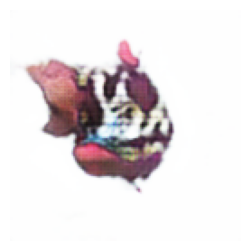

1/1 [==============================] - 0s 25ms/step


array([[73.06208]], dtype=float32)

In [24]:

noise = np.random.normal(0, 1, (1, 100))
generated_thumbnails = m.generator.predict(noise)
visualize_preprocessed_image(generated_thumbnails[0], (3,3))
m.discriminator.predict(generated_thumbnails)

# Judge a real pokemon

Images in /home/anthony/workspace/yt-data/pokemon
['emolga.png.jpg', 'roserade.png.jpg', 'grubbin.jpg', 'pyroar.png', 'prinplup.png', 'amaura.png', 'whiscash.png', 'inkay.png', 'geodude.png', 'granbull.png.jpg']
Found 1530 total files
Found 809 jpgs


100%|██████████| 809/809 [00:00<00:00, 1917.61it/s]


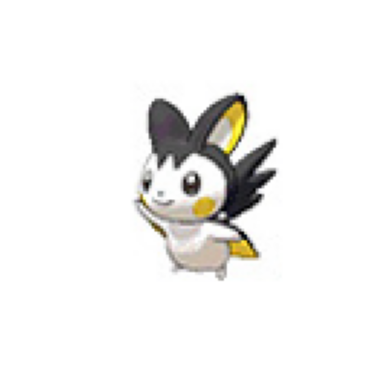

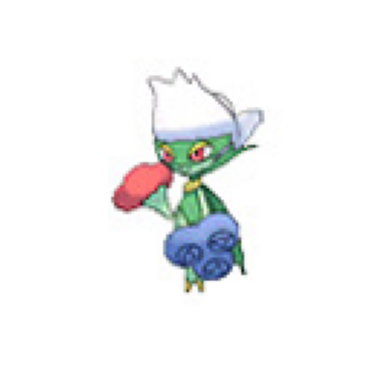

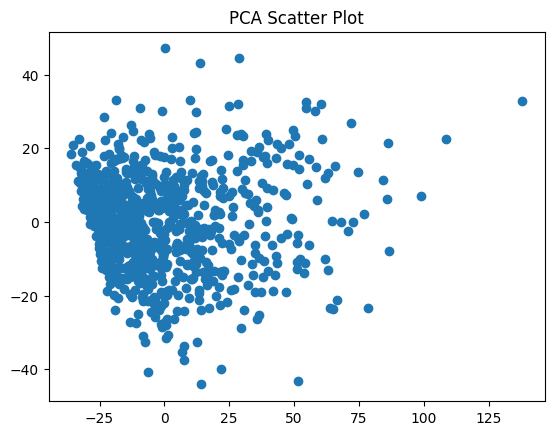

(809, 128, 128, 3)

In [13]:
from thumbs.data import get_pokemon_data
images = get_pokemon_data()
images.shape

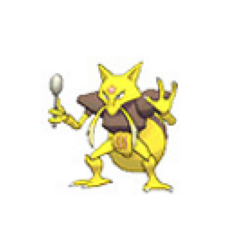

1/1 [==============================] - 0s 31ms/step


array([[73.763985]], dtype=float32)

In [32]:
real_pokemon = images[np.random.randint(0, images.shape[0], 1)]
visualize_preprocessed_image(real_pokemon[0], (3,3))
m.discriminator.predict(real_pokemon)